In [1]:
suppressPackageStartupMessages(library(motifbreakR))
suppressPackageStartupMessages(library(MotifDb))
suppressPackageStartupMessages(library(BSgenome))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library("BSgenome.Hsapiens.UCSC.hg19"))
suppressPackageStartupMessages(library(motifStack))
suppressPackageStartupMessages(library(data.table))
library(stringr)
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(ggplot2))
#library(MotIV)
library(pheatmap)


See system.file("LICENSE", package="MotifDb") for use restrictions.

Warning message:
“replacing previous import ‘S4Vectors::as.data.frame’ by ‘motifStack::as.data.frame’ when loading ‘motifbreakR’”


In [2]:
setwd("/nfs/lab/projects/pbmc_snATAC/analysis_v2/")

In [6]:
allvars = read.table('example_boxplots/All_tested_genotypes.tsv', header=T)

In [10]:
allvars = rownames(allvars) [!( rownames(allvars) %in% vars1$V4) ]

In [14]:
spt = str_split_fixed(allvars, "\\:", 4)

In [18]:
newinps = data.frame(spt[,1], as.numeric(spt[,2])-1, spt[,2], allvars, 0, "+" )
newinps = newinps[!duplicated(newinps),]

In [34]:
dim(newinps)

[1] 75695     6

In [26]:
write.table( newinps, "motifbreak_enrichment/Input_caQTL_list_new.tsv", sep="\t", quote=F, row.names=F, col.names=F)

### Run the analysis
example here, run as Rscript for the rest

In [3]:
setwd('/nfs/lab/projects/pbmc_snATAC/analysis_v2/motifbreak_enrichment/')

In [2]:
hocomoco2 = MotifDb[mcols(MotifDb)$dataSource=='HOCOMOCOv10' & mcols(MotifDb)$organism=='Hsapiens']


In [6]:
snps <- snps.from.file(file = "Input_caQTL_list_new.tsv",
                                  search.genome = BSgenome.Hsapiens.UCSC.hg19,
                                  format = "bed")

In [10]:
snps <- snps.from.file(file = "carolyn_test",
                                  search.genome = BSgenome.Hsapiens.UCSC.hg19)

In [17]:
snps

GRanges object with 1 range and 3 metadata columns:
                    seqnames    ranges strand |            SNP_id
                       <Rle> <IRanges>  <Rle> |       <character>
  chr6:33075635:A:G     chr6  33075635      * | chr6:33075635:A:G
                               REF            ALT
                    <DNAStringSet> <DNAStringSet>
  chr6:33075635:A:G              A              G
  -------
  seqinfo: 1 sequence from hg19 genome

In [12]:
caro =as.data.frame(motifbreakR(snpList = snps[1], filterp = TRUE,
                       pwmList = hocomoco2,
                       method="ic",
                       threshold = 5e-4,
                       BPPARAM = BiocParallel::bpparam("SerialParam")))

In [16]:
write.table(caro, "rs3117230.tsv", quote=F, sep="\t")

In [32]:
results <- mclapply(1:200, function(x) data.frame(motifbreakR(snpList = snps[x], filterp = TRUE,
                       pwmList = hocomoco2,
                       method="ic",
                       threshold = 5e-4,
                       BPPARAM = BiocParallel::bpparam("SerialParam"))), mc.cores=48 )

rb = rbindlist(results[lapply(results, class) == "data.frame"])


In [50]:
n = length(snps)
s =seq(1,n, by=200)
end = s[length(s)-1]

In [39]:
#### /usr/bin/Rscript/Rscript  (3.6.0)

for (i in seq(1,n, by=200)){

  test=snps[i:(i+199)]
  results <- mclapply(1:200, function(x) data.frame(motifbreakR(snpList = test[x], filterp = TRUE,
                       pwmList = hocomoco2,
                       method="ic",
                       threshold = 5e-4,
                       BPPARAM = BiocParallel::bpparam("SerialParam"))), mc.cores=18 )

rb = rbindlist(results[lapply(results, class) == "data.frame"])

if(nrow(rb)>0){
  write.table(rb, paste0("hocomoco/Results_Hocomoco_", i, "_", i+199, ".tsv"), quote=F, row.names=F, sep="\t")  
}

}   


In [52]:
i=end+200

test=snps[i:n]
  results <- mclapply(1:length(test), function(x) data.frame(motifbreakR(snpList = test[x], filterp = TRUE,
                       pwmList = hocomoco2,
                       method="ic",
                       threshold = 5e-4,
                       BPPARAM = BiocParallel::bpparam("SerialParam"))), mc.cores=18 )

rb = rbindlist(results[lapply(results, class) == "data.frame"])

if(nrow(rb)>0){
  write.table(rb, paste0("hocomoco/Results_Hocomoco_", i, "_", n, ".tsv"), quote=F, row.names=F, sep="\t")  
}



### Read in the results

In [53]:
files = list.files('hocomoco')[grepl("Results_Hocomoco", list.files('hocomoco'))]

In [57]:
RES = data.frame()
for( f in files){
    res = read.table(paste0('hocomoco/',f),  row.names=NULL, header=T, sep="\t", stringsAsFactors = F)
    RES = rbind(RES, res)
}

tab = RES[, c(6,10:24)]
tab = tab[order(-abs(tab$alleleDiff)),]
tab = tab[!duplicated(tab[,c('SNP_id','geneSymbol' )]),]

dim(tab)

write.table(tab, "Summary_significant_motifs_hocomocov10_part3.tsv", sep="\t", row.names=F, quote=F)

strong = subset(tab,effect=="strong" )

### Calculate Enrichment

In [4]:
tab1 = read.table("Summary_significant_motifs_hocomocov10.tsv", sep="\t", header=T, stringsAsFactors = F)
tab2 = read.table("Summary_significant_motifs_hocomocov10_part2.tsv", sep="\t", header=T, stringsAsFactors = F)
tab3 = read.table("Summary_significant_motifs_hocomocov10_part3.tsv", sep="\t", header=T, stringsAsFactors = F)

tab = rbind(tab1,tab2,tab3)

In [5]:
tab = tab[!duplicated(tab),]
strong = subset(tab,effect=="strong" )

In [6]:
vars1   = read.table("Input_caQTL_list_old.tsv")
vars2 = read.table("Input_caQTL_list_new.tsv")
inputvars = rbind ( as.matrix(unname(vars1)), as.matrix(unname(vars2) ))

In [7]:
inputvars = inputvars[!duplicated(inputvars),]

In [8]:
dim(inputvars)

[1] 209064      6

In [9]:
anno = read.table("../summarized_caqtls/run3/EUR_caqtl_leads_run3.tsv", header=T )

In [10]:
sub = anno[!(anno$cell %in% 'bulk') ,]

In [11]:
r = data.frame(  varID =  sub$varID, rsID = sub$rsID,
                 qtl = as.numeric(sub$flag_fdr10 & sub$exclude==FALSE)+1, cell=sub$cell)
r = r[order(-r$qtl),]
r = subset(r, !duplicated(r[,c("varID", "cell")]))

wide = spread(r, cell, qtl, fill =0)
### this table will display  for each cell if the snp was a caqtl (2), tested but no qtl (1) or not tested (0)

###subset because the tested vatiants migt be different
wide_test = subset(wide, varID %in% inputvars[,4])

In [12]:
dim(wide_test)

[1] 152722     21

In [13]:
wide_test = subset(wide_test, rowSums(wide_test[,3:ncol(wide_test)])>0)

In [14]:
totest = data.frame(qtl = rowSums(wide_test[,3:ncol(wide_test)]==2)>0, motdi = wide_test$varID %in% strong$SNP_id)

In [15]:
sum(duplicated(wide_test$varID))
sum(totest$qtl)
table(totest)

[1] 0

[1] 8798

       motdi
qtl      FALSE   TRUE
  FALSE   7034 136890
  TRUE     348   8450

In [16]:
sum(totest$motdi)

[1] 145340

In [17]:
fisher.test(table(totest))


	Fisher's Exact Test for Count Data

data:  table(totest)
p-value = 5.18e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.117583 1.396575
sample estimates:
odds ratio 
  1.247727 


In [18]:
ag = aggregate(SNP_id~geneSymbol, strong, length)
ag = ag[order(-ag$SNP_id),]
tfs = ag[ag[,2]>2,1]
length(tfs)

[1] 595

In [19]:
tfs_all = tfs

#### Binomial test

In [20]:
celltypes = c('b', 'mono', "nk", "t")

In [21]:
binolist = summarylist = list()
for(cell in celltypes){
dd   = wide_test[wide_test[,cell]>0, c("varID", cell)]
tot  = sapply(tfs_all, function(x) sum(dd$varID %in% strong$SNP_id[strong$geneSymbol == x])/sum(dd$varID %in% strong$SNP_id))
freq = sapply(tfs_all, function(x) sum(dd$varID[dd[,2]==2] %in% strong$SNP_id[strong$geneSymbol == x]))
freqtot =  sapply(tfs_all, function(x) sum(dd$varID %in% strong$SNP_id[strong$geneSymbol == x]))
btest = sapply(1:length(tfs_all), function(x) binom.test(freq[x], sum(dd[,2]==2),p=tot[x],alternative="greater")$p.value)
sumdf = data.frame(all_tf =freqtot , qtl_tf=freq,  
                   all_any= sum(dd$varID %in% strong$SNP_id),  
                   tot_qtl = sum(dd[,2]==2),
                    bt = btest)
sumdf$fdr = p.adjust(sumdf$bt, method = "BH")
binolist[[cell]] = btest 
summarylist[[cell]]= sumdf
               }

In [1]:
dir.create("summary_tables")

In [22]:
for (cell in celltypes){
write.csv (summarylist[[cell]], 
           paste0('summary_tables/',cell, ".binotest_motifs.csv" ))
    }

In [23]:
btest = sapply(binolist, unlist )
rownames(btest) = tfs_all
write.csv(btest, "Binomial.p_values.csv")

In [24]:
bh = apply(btest, 2, p.adjust, method = "BH")

In [25]:
colSums (bh<0.05)

b mono   nk    t 
  29   86   35   39

In [26]:
ranking = apply(btest, 2,rank)
topranking = ranking[order(rowSums(ranking)),]
topranking = topranking[rowSums(topranking < 23)==4,]
top10 = rownames(topranking)[1:10]

In [27]:
top10

[1] "GABP1" "ETV6"  "FLI1"  "EHF"   "GABPA" "ETV4"  "ELF2"  "ELF1"  "ETS1" 
[10] "ELK4"

In [160]:
cells = c( "b","t","mono")

In [161]:
sigtf = rownames(bh[rowSums(bh<0.05)>0,])

In [229]:
figs = top10
for (c in cells){

b= ranking[bh[,c]<0.05 ,]
b=  b[b[,c]== apply(b[,cells],1,min),]
toptf = rownames(b[order(b[,c]),]) 
toptf = toptf[!(toptf %in% figs)]
bb = toptf [1:15]
    #names(bb)= rep(c,20)
cat(c,   na.omit(toptf [1:15]) , '\n')
    
    figs = c(figs,na.omit(bb))
}

b SPI1 ELF5 SPIB FEV ERG CREB1 IRF1 CR3L1 E4F1 CREM BC11A IRF4 
t ELK1 CTCFL CTCF ETV1 RUNX2 PEBB ELF3 RUNX3 RUNX1 ELK3 CREB3 ATF1 SP3 PLAL1 SPDEF 
mono ETV7 JUND JUN CEBPA FOS ETS2 CEBPB CEBPD FOSB FOSL1 FOSL2 CEBPG JUNB DBP BATF 


In [166]:
#test = apply(btest[sigtf,], 2, function(x) rev(colorRampPalette( brewer.pal(9, "YlGnBu") )(length(sigtf)) )[rank(x)] )
#rownames(test)= sigtf
#test = test[figs,]

In [230]:
figs = rev(readLines("tf_list_plot"))

In [231]:
test = apply(btest[figs,], 2, function(x) rev(colorRampPalette( brewer.pal(9, "YlGnBu") )(length(figs)) )[rank(x)] )
rownames(test)= figs

In [235]:
rk =apply( btest[figs,],2,rank )

In [241]:
pheatmap (rk,cluster_rows = F, cluster_cols = F,cellwidth = 10, cellheight = 10,
          gaps_row = c(10,20,30),
file ="../figures/pheatmap_motifs_manual.pdf",
          col=rev(colorRampPalette( brewer.pal(9, "YlGnBu") )(40)))

In [232]:
write.table(test, "heatmap.toplot.tsv")

In [202]:
getwd()

[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/motifbreak_enrichment"

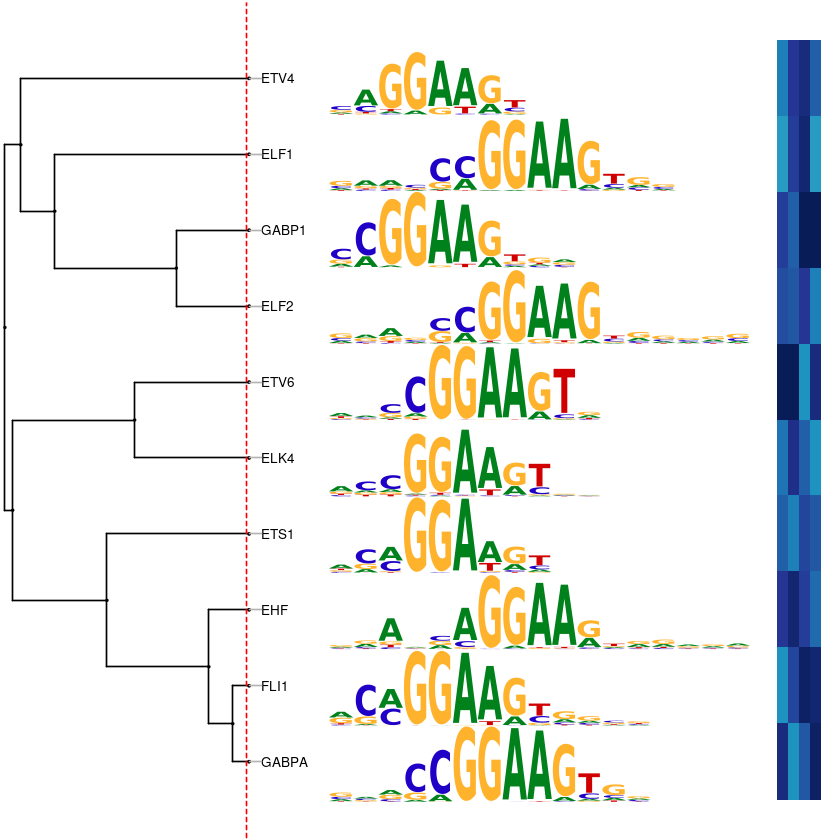

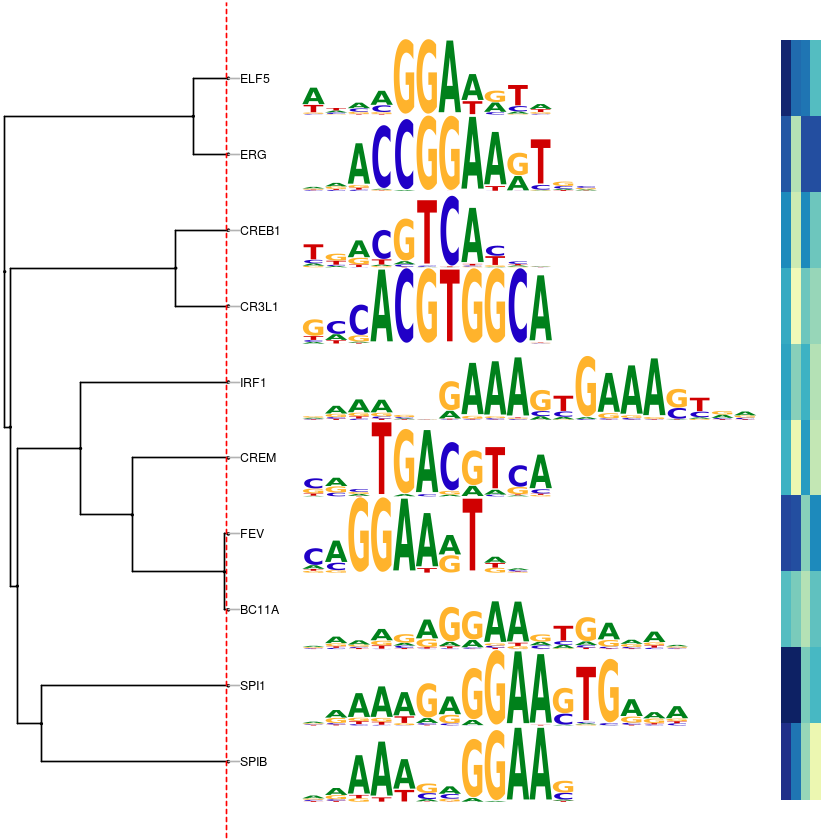

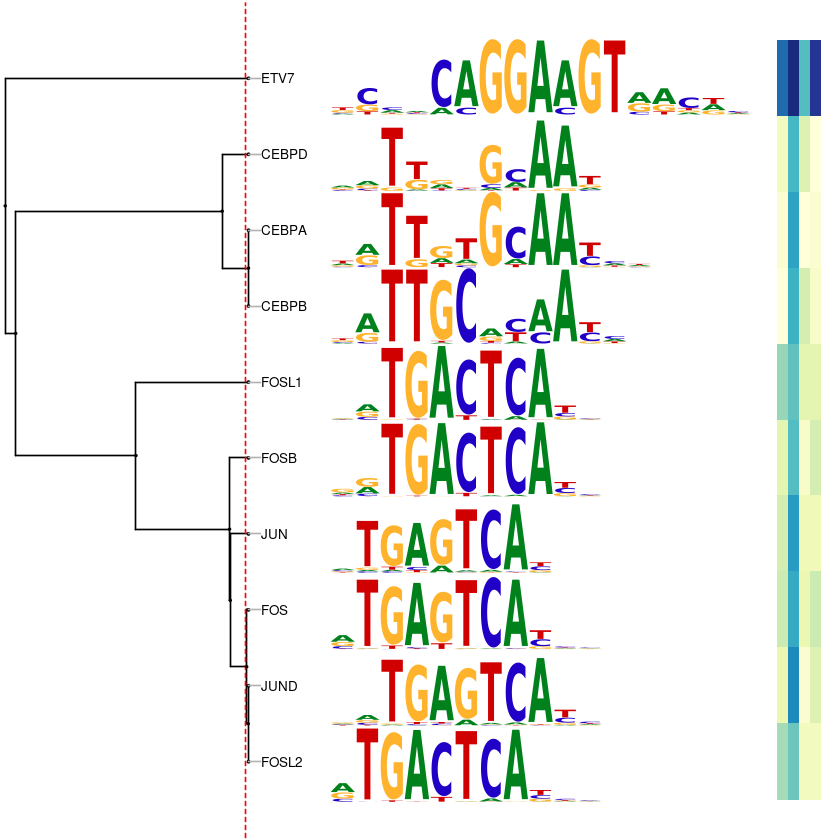

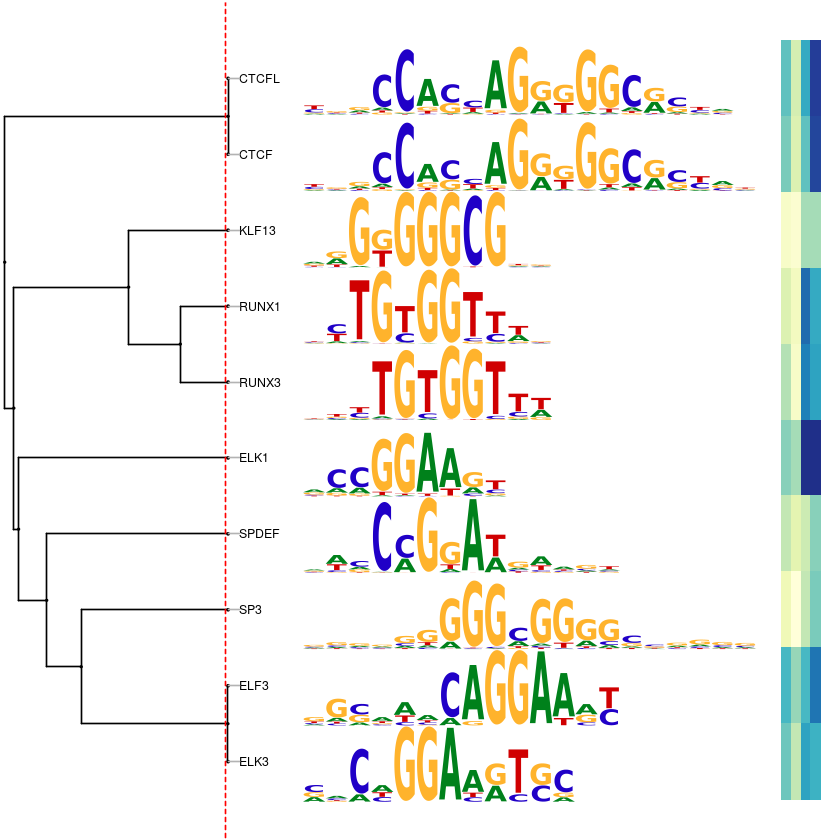

In [233]:
#### Must Run this chunk in R terminal

test = read.table("heatmap.toplot.tsv", header=T, stringsAsFactor=F)

figs = rownames(test)

hocomoco2 = MotifDb[mcols(MotifDb)$dataSource=='HOCOMOCOv10' & mcols(MotifDb)$organism=='Hsapiens']

#pdf("../figures/heatmap_motifs.pdf")
for( i in 1:4 ) {
x=c(1, 11, 21,31)[i]
y=c(10,20, 30,40)[i]   
    tfs = figs[x:y]

motifs = query(hocomoco2,  orStrings =paste0(tfs, "_"),  andStrings=c("HOCOMOCOv10", "hsapiens"))
names(motifs) <- str_split_fixed( elementMetadata(motifs)$providerName, "\\_",2)[,1]
motifs = motifs[unique(names(motifs))]


d      <- MotIV::motifDistances(lapply(motifs, pfm2pwm))
hc     <- MotIV::motifHclust(d, method="average")
phylog <- hclust2phylog(hc)
leaves <- names(phylog$leaves)
motifs <- motifs[leaves]
pfms <- mapply(motifs, names(motifs), FUN=function(.pfm, .name){ new("pfm",mat=.pfm, name=.name)})
#df = data.frame(-log10(btest[leaves, 1:4]))

test2 = test[leaves,]
dl = list(test2[,1],test2[,2],test2[,3],test2[,4] )
motifPiles(phylog=phylog, pfms=pfms, 
           r.anno=rep(0.02, length(dl)), 
           col.anno=dl,
           motifScale="logarithmic",
           plotIndex=TRUE,
           groupDistance=0.01)
            }
      #dev.off()   

#### Fisher test

In [189]:
fisherlist = list()
for(cell in celltypes){
dd   = wide_test[wide_test[,cell]>0, c("varID", cell)]
yy = unlist(mclapply(tfs_all, function(x) sum(dd$varID[dd[,2]==2] %in% strong$SNP_id[strong$geneSymbol == x]), mc.cores=32))
ny = unlist(mclapply(tfs_all, function(x) sum(dd$varID[dd[,2]==1] %in% strong$SNP_id[strong$geneSymbol == x]), mc.cores=32))
yn = unlist(mclapply(tfs_all, function(x) sum(!(dd$varID[dd[,2]==2] %in% strong$SNP_id[strong$geneSymbol == x])), mc.cores=32))
nn = unlist(mclapply(tfs_all, function(x) sum(!(dd$varID[dd[,2]==1] %in% strong$SNP_id[strong$geneSymbol == x])), mc.cores=32))

fishtab = as.data.frame(mclapply(1:length(tfs_all), 
        function(x) unlist(fisher.test(matrix(c(nn[x],ny[x],yn[x],yy[x]), ncol=2))[c("p.value", "estimate")]), 
                              mc.cores = 32))

colnames(fishtab)= tfs_all
fisherlist[[cell]] = fishtab
                 }

In [194]:
pvals = t(rbind(fisherlist[[1]][1,], fisherlist[[2]][1,], fisherlist[[3]][1,], fisherlist[[4]][1,] ))
ors = t(rbind(fisherlist[[1]][2,], fisherlist[[2]][2,], fisherlist[[3]][2,], fisherlist[[4]][2,] ))
colnames(pvals) = colnames(ors) = celltypes

In [211]:
bhf = apply(pvals, 2, p.adjust, method = "BH")

In [212]:
colSums (bhf<0.05)

b mono   nk    t 
  32   99   40   57

In [250]:
sig = bhf[rowSums(bhf<0.05)>0,]

In [251]:
sig_all = bhf[rowSums(bhf<0.05)==4,]

In [252]:
orz = t(scale(t(ors)))

In [248]:
sig_all = sig_all[order(rowMeans(sig_all)),]

In [256]:
ranking = apply(pvals, 2,rank)
topranking = ranking[order(rowSums(ranking)),]
topranking = topranking[rowSums(topranking < 23)==4,]

top10 = rownames(topranking)[1:10]

### output suppmentary table

In [47]:
getwd()

[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/motifbreak_enrichment"

In [44]:

for (cell in celltypes){
bt = read.csv(paste0('summary_tables/',cell, ".binotest_motifs.csv" ))
bt = bt[order(bt$bt),]
if(cell ==celltypes[1]){
    BT = bt
} else{
    BT = cbind(BT, bt)
    }
    }

In [45]:
write.csv(BT, 'summary_tables/combined.table.bino.csv')

In [46]:
celltypes

[1] "b"    "mono" "nk"   "t"

### Other plotting method

In [3]:
setwd('/nfs/lab/projects/pbmc_snATAC/analysis_v2/motifbreak_enrichment/')

In [4]:
hocomoco2 = MotifDb[mcols(MotifDb)$dataSource=='HOCOMOCOv10' & mcols(MotifDb)$organism=='Hsapiens']


In [9]:
btest = read.csv( "Binomial.p_values.csv", row.names=1)

In [10]:
bh = apply(btest, 2, p.adjust, method = "BH")

In [11]:
figs = rev(readLines("tf_list_plot"))

In [12]:
rk =apply( btest[figs,],2,rank )

In [13]:
rk[(bh[figs[],]>0.05)  ] <- NA

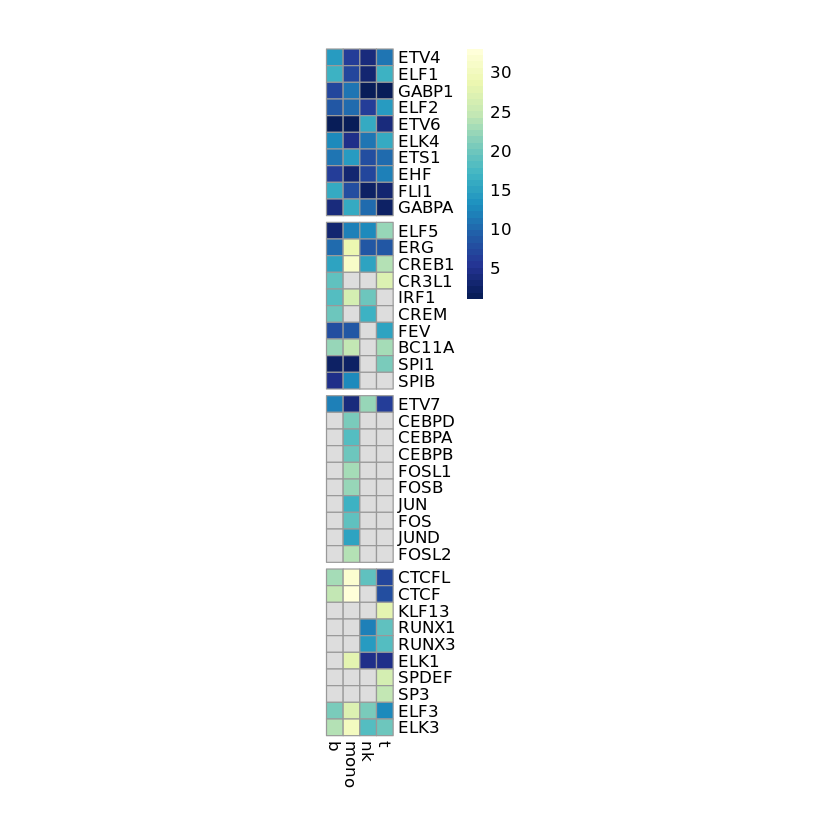

In [14]:
pheatmap (rk,cluster_rows = F, cluster_cols = F,cellwidth = 10, cellheight = 10,
          gaps_row = c(10,20,30),
#file ="../figures/pheatmap_motifs_manual.pdf",
          col=rev(colorRampPalette( brewer.pal(9, "YlGnBu") )(40)))